# Capstone Part 1
Nati Marcus

For my capstone project, I have chosen to create a movie recommendation system based off data from Netflix, Hulu, Amazon Prime Video, and Disney+.

## Problem Statement
All major TV and movie streaming platforms today have their own recommendations built into their software. However, each streaming service is only able to recommend whichever movies are currently on its respective platform.  To solve this problem, I will build a recommender system model for movies on Netflix, Hulu,  Amazon Prime Video, and Disney+ to predict which movies to recommend to a user in one location. I will use movie description, actors, genre, and sub genre to compare movies with cosine similarity. The model will be evaluated based on the cosine similarity scores between titles in the dataset. 

## Data Source:
https://www.kaggle.com/ruchi798/movies-on-netflix-prime-video-hulu-and-disney

In [42]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
#reading in dataset from rt score collection
df = pd.read_csv('data/total_webscraped.csv',index_col=0)

In [46]:
df.head()

,id,movie,year,age_rating,imdb_fan_score,rt_critic_score,netflix,hulu,prime_video,disney_plus,...,genres,country,language,movie_len_mins,rt_movie_link,rt_audience_score,imdb_cast_link,actors,desc,imdb_movie_id
0,1,Inception,2010,13+,8.8,87%,1,0,0,0,...,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0,https://www.rottentomatoes.com/m/inception,0.91,https://www.imdb.com/title/tt1375666/fullcredits,"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...",NaN,tt1375666
1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,...,"Action,Sci-Fi",United States,English,136.0,https://www.rottentomatoes.com/m/the_matrix,0.85,https://www.imdb.com/title/tt0133093/fullcredits,"['Keanu Reeves', 'Laurence Fishburne', 'Carrie...",NaN,tt0133093
2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,...,"Action,Adventure,Sci-Fi",United States,English,149.0,https://www.rottentomatoes.com/m/avengers_infi...,0.91,https://www.imdb.com/title/tt4154756/fullcredits,"['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...",NaN,tt4154756
3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,...,"Adventure,Comedy,Sci-Fi",United States,English,116.0,https://www.rottentomatoes.com/m/back_to_the_f...,0.94,https://www.imdb.com/title/tt0088763/fullcredits,"['Michael J. Fox', 'Christopher Lloyd', 'Lea T...",NaN,tt0088763
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,...,Western,"Italy,Spain,West Germany",Italian,161.0,https://www.rottentomatoes.com/m/the_good_the_...,0.97,https://www.imdb.com/title/tt0060196/fullcredits,"['Eli Wallach', 'Clint Eastwood', 'Lee Van Cle...",NaN,tt0060196


In [47]:
#checking null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16744 entries, 0 to 7
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 16744 non-null  int64  
 1   movie              16744 non-null  object 
 2   year               16744 non-null  int64  
 3   age_rating         7354 non-null   object 
 4   imdb_fan_score     16173 non-null  float64
 5   rt_critic_score    5158 non-null   object 
 6   netflix            16744 non-null  int64  
 7   hulu               16744 non-null  int64  
 8   prime_video        16744 non-null  int64  
 9   disney_plus        16744 non-null  int64  
 10  directors          16018 non-null  object 
 11  genres             16469 non-null  object 
 12  country            16309 non-null  object 
 13  language           16145 non-null  object 
 14  movie_len_mins     16152 non-null  float64
 15  rt_movie_link      16744 non-null  object 
 16  rt_audience_score  16744 n

In [48]:
#function to change numbers in string format to float percent (e.g. '84%' --> 0.84)  
def pct_to_float(rating):
    try:
        return int(rating.split('%')[0])/100
    except:
        pass

In [49]:
#changing rotten tomatoes critic scores from string to float
df['rt_critic_score'] = df['rt_critic_score'].apply(pct_to_float)

In [50]:
#checking all age rating catgeories to convert to numerical
df['age_rating'].value_counts()

18+    3474
7+     1462
13+    1255
all     843
16+     320
Name: age_rating, dtype: int64

In [51]:
#creating 1-5 categories for age_rating
df['age_rating'] = df['age_rating'].map({'18+':5,'16+':4,'13+':3,'7+':2,'all':1})

In [52]:
#changing imdb score from scale of 1-10 to decimal percentage
df['imdb_fan_score'] = df['imdb_fan_score']/10

In [53]:
#changing rotten tomatoes audience score from string to float and NaN if no score exists
df['rt_audience_score'] = df['rt_audience_score'].map(lambda x: float(x) if x != 'no score' else np.nan)

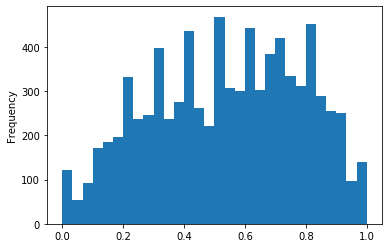

In [54]:
#creating a histogram to display distribution of rotten tomatoes audience scores
df['rt_audience_score'].plot(kind='hist',bins=30);

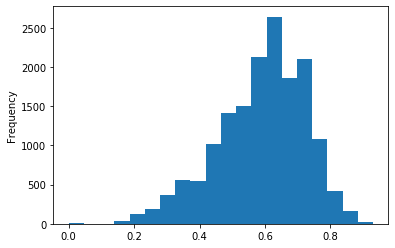

In [55]:
#creating a histogram to display the distribution of imdb fan scores
df['imdb_fan_score'].plot(kind='hist',bins=20);

In [56]:
#seeing what the different genres are for the movies
df['genres'].value_counts()

Drama                                                   1341
Documentary                                             1229
Comedy                                                  1040
Comedy,Drama                                             446
Horror                                                   436
                                                        ... 
Animation,Action,Crime,Drama,Mystery,Sci-Fi,Thriller       1
Adventure,Comedy,Crime,Family                              1
Short,Comedy,Drama,History,Thriller                        1
Comedy,Drama,Fantasy,Horror,Mystery,Thriller               1
Animation,Action,Drama,Romance,Sport                       1
Name: genres, Length: 1909, dtype: int64

In [57]:
df['country'].value_counts()

United States                            8776
India                                    1064
United Kingdom                            905
Canada                                    555
Australia                                 202
                                         ... 
Italy,Switzerland                           1
Norway,Denmark,Netherlands,Sweden           1
China,India                                 1
United States,United Kingdom,Brazil         1
Georgia,France,United Kingdom,Germany       1
Name: country, Length: 1303, dtype: int64

In [58]:
df['language'].value_counts()

English                             10955
Hindi                                 503
English,Spanish                       276
Spanish                               267
English,French                        174
                                    ...  
Hindi,Bhojpuri                          1
English,French,Khmer,Russian            1
English,Spanish,Korean                  1
Icelandic,Swedish,French,English        1
German,English,Polish,Swedish           1
Name: language, Length: 1102, dtype: int64

In [59]:
#function that returns 2nd value from a list of values in a given column
def sub_val(value):
    if ',' in str(value):
        return value.split(',')[1]
    else:
        return np.nan

In [60]:
df['sub_genre'] = df['genres'].apply(sub_val)

In [61]:
#function that returns only first value from a list of values in a given column
def top_val(value):
    if ',' in str(value):
        return value.split(',')[0]
    else:
        return value

In [62]:
df['top_genre'] = df['genres'].apply(top_val)
df['country'] = df['country'].apply(top_val)
df['language'] = df['language'].apply(top_val)

In [63]:
#creating platform specific dataframes for four different models
netflix_df = df[df['netflix'] == 1].drop(columns=['netflix','hulu','prime_video','disney_plus'])
hulu_df = df[df['hulu'] == 1].drop(columns=['netflix','hulu','prime_video','disney_plus'])
prime_df = df[df['prime_video'] == 1].drop(columns=['netflix','hulu','prime_video','disney_plus'])
disney_df = df[df['disney_plus'] == 1].drop(columns=['netflix','hulu','prime_video','disney_plus'])

In [64]:
#looking at the shapes of all these dataframes
print(f'''netflix dataset has {netflix_df.shape[0]} observations, and {netflix_df.shape[1]} features\n
hulu dataset has {hulu_df.shape[0]} observations, and {hulu_df.shape[1]} features\n
prime video dataset has {prime_df.shape[0]} observations, and {prime_df.shape[1]} features\n
disney+ dataset has {disney_df.shape[0]} observations, and {disney_df.shape[1]} features
''')

netflix dataset has 3560 observations, and 19 features

hulu dataset has 903 observations, and 19 features

prime video dataset has 12354 observations, and 19 features

disney+ dataset has 564 observations, and 19 features



In [65]:
df['directors'] = df['directors'].apply(top_val)

In [66]:
names = df['directors'].value_counts().index.to_list()
counts = df['directors'].value_counts().to_list()

In [67]:
len(names) == len(counts)

True

In [68]:
counts_dict = {}
for i in range(len(names)):
    counts_dict[names[i]] = counts[i]

In [69]:
df['directors_ordinal'] = df['directors'].map(counts_dict)

In [73]:
df = df.drop(columns=['id','netflix','hulu','prime_video','disney_plus','rt_movie_link',
                     'imdb_cast_link','imdb_movie_id','directors'])

In [75]:
df.to_csv('data/all_platforms_clean_for_modeling.csv')

In [25]:
#creating df for analysis
names = ['netflix','hulu','prime','disney']
for i in range(len(streaming_services)):
    streaming_services[i].to_csv(f'{names[i]}.csv')